## Fine-tuning CNN for AI-generated Image Detection
In this notebook, we will explore the task of classifying images as real or AI-generated using fine-tuning techniques with several well-known CNN architectures. For this classification task, we will use the CIFAKE dataset, which includes both real and AI-generated images.

Link for the dataset: [CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image

In [6]:
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/


In [7]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = val_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


Larger batch sizes are expected to result in significantly longer training times, especially with a substantial training set of 100,000 images. However, the compact size of the images effectively reduces the impact on training duration.

In [39]:
def plot_metrics(history, metric, filename_prefix=None):
    plt.figure()
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    if filename_prefix:
        filename = f"{filename_prefix}_{metric}.png"
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()

    
# Constant values that will be shared by all the models
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) 

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom((0.9, 1.1)),
    tf.keras.layers.RandomFlip(mode="horizontal")
])

### Model Building

All the models share the same architecture for a fair comparison: the input layer, followed by the base model with pre-trained weights from the imagenet, then a few dense layers, and then a unit output with a sigmoid activation function. 

Training is conducted with early stopping criteria monitoring the validation loss, and the best weights will be restored once the training is completed.

In [10]:
# Building the Transfer Learning model using ResNet50
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
ResNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = data_augmentation(inputs)
x = ResNet_base_model(x, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
ResNet_model = tf.keras.Model(inputs, outputs)

# Compile the model
ResNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Summary of the model
ResNet_model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448  

In [ ]:
# Visualize the ResNet model architecture
tf.keras.utils.plot_model(ResNet_model, show_shapes = True, to_file = 'ResNet_model.png')
Image('ResNet_model.png')

In [12]:
# Train the Transfer Learning model
print("Starting training with Transfer Learning using ResNet50...")
ResNet_model_history = ResNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

I0000 00:00:1745734285.016638     135 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 245s 1s/step - loss: 1.6404 - accuracy: 0.9113 - precision: 0.9115 - recall: 0.9112 - val_loss: 0.7371 - val_accuracy: 0.8945 - val_precision: 0.8316 - val_recall: 0.9892
Epoch 2/100
200/200 [==============================] - 33s 160ms/step - loss: 0.3691 - accuracy: 0.9456 - precision: 0.9466 - recall: 0.9445 - val_loss: 1.1993 - val_accuracy: 0.7357 - val_precision: 0.6543 - val_recall: 0.9993
Epoch 3/100
200/200 [==============================] - 32s 155ms/step - loss: 0.2023 - accuracy: 0.9563 - precision: 0.9562 - recall: 0.9565 - val_loss: 0.2761 - val_accuracy: 0.9229 - val_precision: 0.8740 - val_recall: 0.9883
Epoch 4/100
200/200 [==============================] - 33s 161ms/step - loss: 0.1533 - accuracy: 0.9633 - precision: 0.9632 - recall: 0.9635 - val_loss: 0.2016 - val_accuracy: 0.9470 - val_precision: 0.9265 - val_recall: 0.9711
Epoch 5/100
200/200 [==============================] - 31s 151ms/step - loss: 0.1299 - accuracy: 0.968

In [13]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = ResNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 5s 95ms/step - loss: 0.1183 - accuracy: 0.9599 - precision: 0.9461 - recall: 0.9755
Val Loss: 0.1183
Val Accuracy: 0.9599
Val Precision: 0.9461
Val Recall: 0.9755


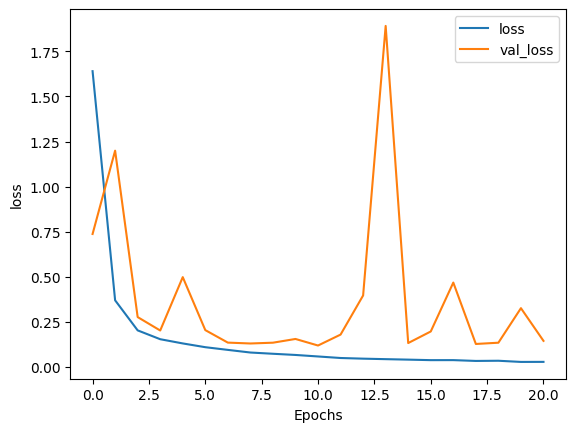

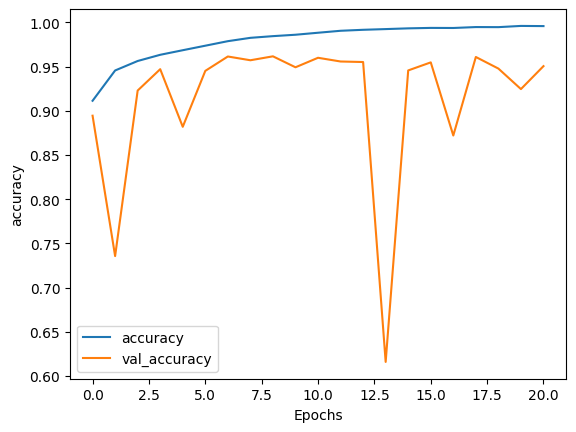

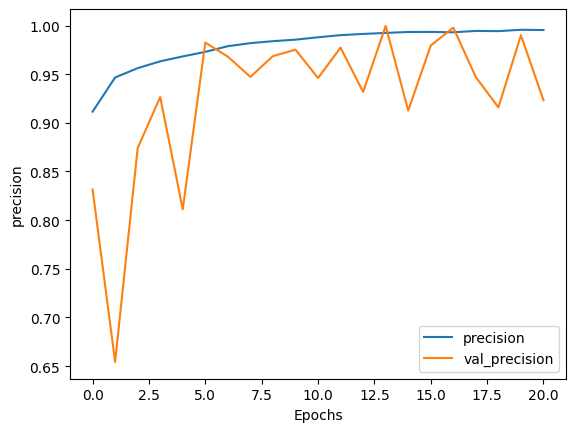

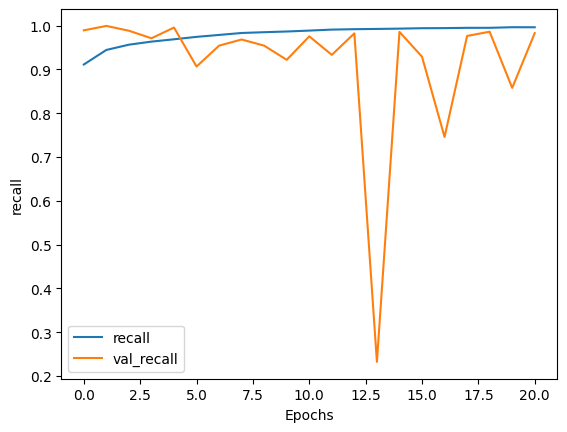

In [38]:
# Plot error rates and metric rates
plot_metrics(ResNet_model_history, 'loss', 'resnet_loss.png')
plot_metrics(ResNet_model_history, 'accuracy', 'resnet_accuracy.png')
plot_metrics(ResNet_model_history, 'precision', 'resnet_precision.png')
plot_metrics(ResNet_model_history, 'recall', 'resnet_recall.png')

In [ ]:
ResNet_model.save("resnet.keras")

In [ ]:
# Building the Transfer Learning model using VGG16
VGG_base_model = tf.keras.applications.VGG16(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
VGG_base_model.trainable = True

# Create a new model on top of the VGG16 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = data_augmentation(inputs)
x = VGG_base_model(x, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
VGG_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
VGG_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
VGG_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448

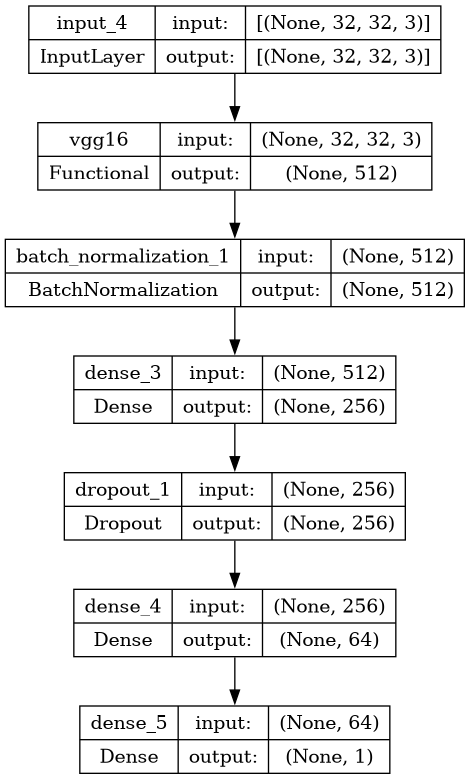

In [ ]:
# Visualize the VGG model architecture
tf.keras.utils.plot_model(VGG_model, show_shapes = True, to_file = 'VGG_model.png')
Image('VGG_model.png')

In [ ]:
print("Starting training with Transfer Learning using VGG16...")
VGG_model_history = VGG_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using VGG16...
Epoch 1/100
200/200 [==============================] - 49s 186ms/step - loss: 1.3825 - accuracy: 0.8262 - precision_1: 0.8102 - recall_1: 0.8520 - val_loss: 0.6592 - val_accuracy: 0.8256 - val_precision_1: 0.7461 - val_recall_1: 0.9872
Epoch 2/100
200/200 [==============================] - 30s 146ms/step - loss: 0.3505 - accuracy: 0.9196 - precision_1: 0.9203 - recall_1: 0.9186 - val_loss: 0.4108 - val_accuracy: 0.8670 - val_precision_1: 0.7947 - val_recall_1: 0.9897
Epoch 3/100
200/200 [==============================] - 34s 163ms/step - loss: 0.2207 - accuracy: 0.9379 - precision_1: 0.9389 - recall_1: 0.9369 - val_loss: 0.2066 - val_accuracy: 0.9340 - val_precision_1: 0.9567 - val_recall_1: 0.9090
Epoch 4/100
200/200 [==============================] - 32s 158ms/step - loss: 0.1782 - accuracy: 0.9465 - precision_1: 0.9490 - recall_1: 0.9438 - val_loss: 0.2015 - val_accuracy: 0.9342 - val_precision_1: 0.8969 - val_recall_1: 0.9813


In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = VGG_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 5s 95ms/step - loss: 0.1427 - accuracy: 0.9616 - precision_1: 0.9599 - recall_1: 0.9635
Val Loss: 0.1427
Val Accuracy: 0.9616
Val Precision: 0.9599
Val Recall: 0.9635


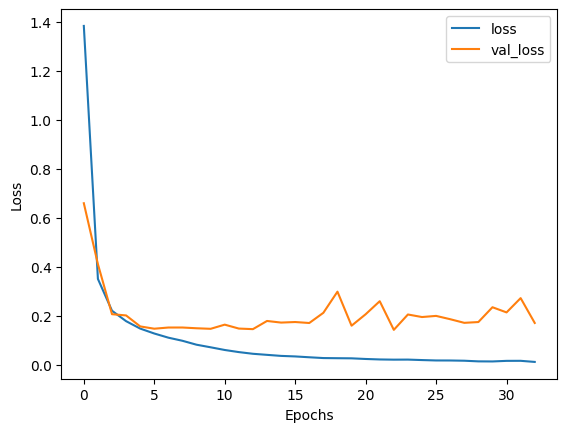

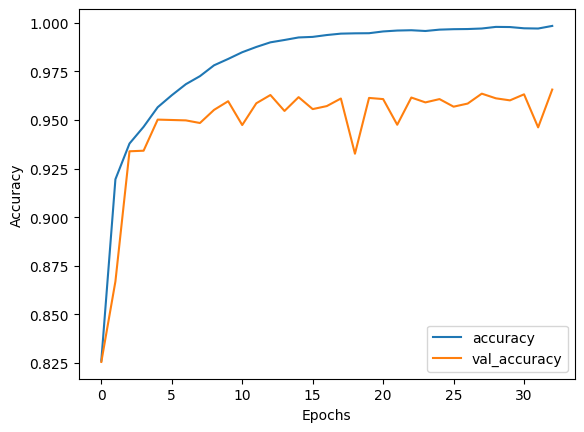

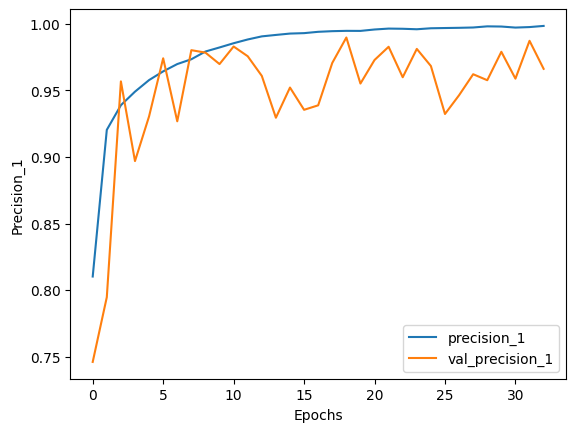

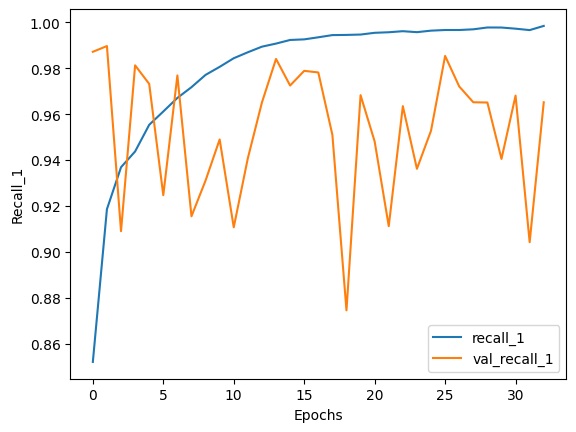

In [40]:
# Plot error rates and metric rates
for metric in ['loss', 'accuracy', 'precision_1', 'recall_1']:
    plot_metrics(VGG_model_history, metric, filename_prefix='vgg')

In [ ]:
VGG_model.save("vgg.keras")

In [ ]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = data_augmentation(inputs)
x = EfficientNet_base_model(x, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
EfficientNet_model.summary()

24274472/24274472 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                            

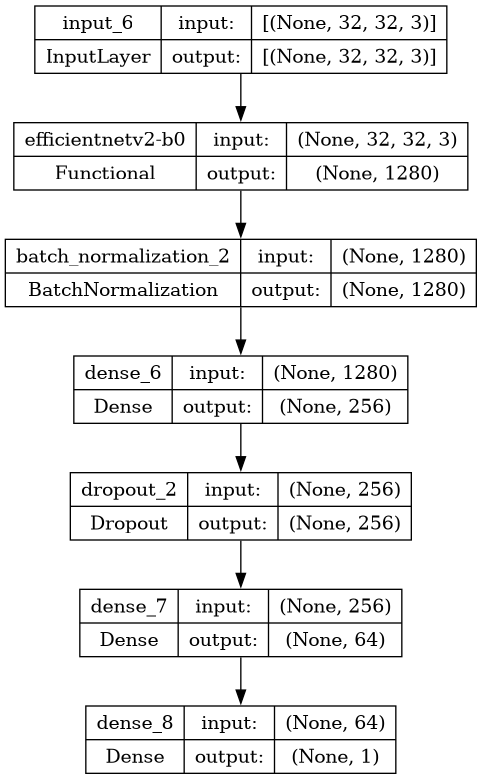

In [ ]:
# Visualize the EfficientNet model architecture
tf.keras.utils.plot_model(EfficientNet_model, show_shapes = True, to_file = 'EfficientNet_model.png')
Image('EfficientNet_model.png')

In [ ]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using EfficientNet...")
EfficientNet_model_history = EfficientNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using EfficientNet...
Epoch 1/100
200/200 [==============================] - 88s 257ms/step - loss: 1.4409 - accuracy: 0.9387 - precision_2: 0.9402 - recall_2: 0.9371 - val_loss: 0.3891 - val_accuracy: 0.9618 - val_precision_2: 0.9613 - val_recall_2: 0.9625
Epoch 2/100
200/200 [==============================] - 51s 249ms/step - loss: 0.2286 - accuracy: 0.9669 - precision_2: 0.9679 - recall_2: 0.9658 - val_loss: 0.1688 - val_accuracy: 0.9647 - val_precision_2: 0.9522 - val_recall_2: 0.9786
Epoch 3/100
200/200 [==============================] - 51s 253ms/step - loss: 0.1314 - accuracy: 0.9765 - precision_2: 0.9768 - recall_2: 0.9761 - val_loss: 0.1506 - val_accuracy: 0.9592 - val_precision_2: 0.9875 - val_recall_2: 0.9302
Epoch 4/100
200/200 [==============================] - 51s 252ms/step - loss: 0.1005 - accuracy: 0.9822 - precision_2: 0.9824 - recall_2: 0.9821 - val_loss: 0.1389 - val_accuracy: 0.9682 - val_precision_2: 0.9525 - val_recall_2: 

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 6s 117ms/step - loss: 0.1145 - accuracy: 0.9713 - precision_2: 0.9759 - recall_2: 0.9665
Val Loss: 0.1145
Val Accuracy: 0.9713
Val Precision: 0.9759
Val Recall: 0.9665


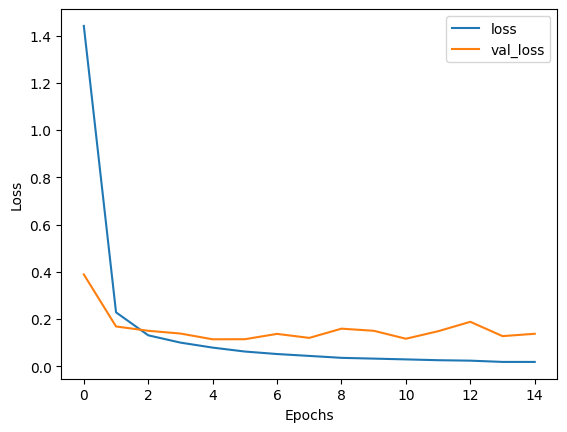

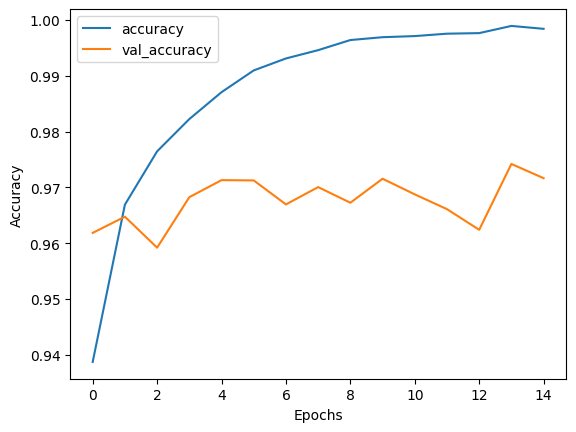

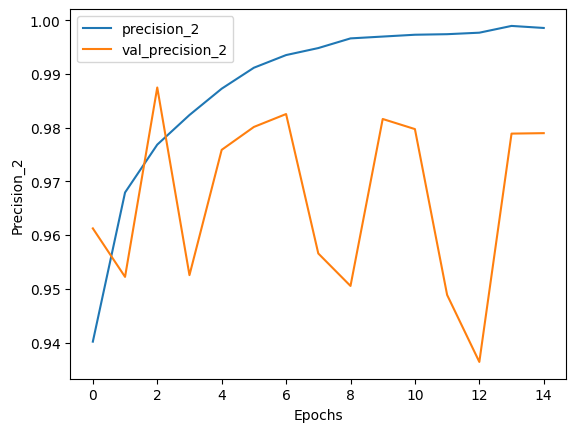

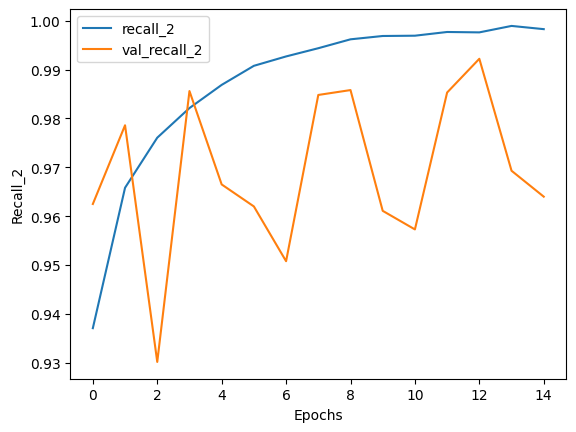

In [41]:
# Plot error rates and metric rates
for metric in ['loss', 'accuracy', 'precision_2', 'recall_2']:
    plot_metrics(EfficientNet_model_history, metric, filename_prefix='efficientnet')

In [ ]:
# Save the EfficientNet model
EfficientNet_model.save("efficientnet.keras")

In [ ]:
# Building the Transfer Learning model using MobileNetV3
MobileNet_base_model = tf.keras.applications.MobileNetV3Small(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
MobileNet_base_model.trainable = True

# Create a new model on top of the MobileNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = data_augmentation(inputs)
x = MobileNet_base_model(x, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
MobileNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
MobileNet_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Build the Transfer Learning model so we can see a summary
MobileNet_model.summary()

4334752/4334752 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 batch_normalization_3 (Bat  (None, 576)               2304      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 256)               147712    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                              

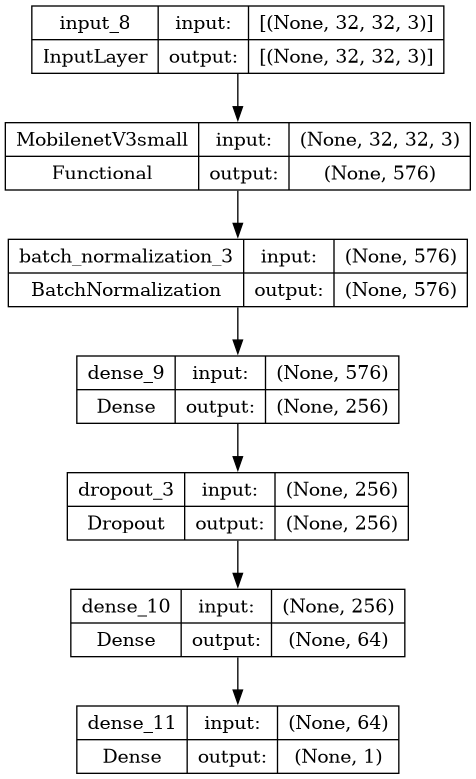

In [ ]:
# Visualize the MobileNet model architecture
tf.keras.utils.plot_model(MobileNet_model, show_shapes = True, to_file = 'MobileNet_model.png')
Image('MobileNet_model.png')

In [ ]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using MobileNet...")
MobileNet_model_history = MobileNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using MobileNet...
Epoch 1/100
200/200 [==============================] - 54s 146ms/step - loss: 0.9150 - accuracy: 0.8650 - precision_3: 0.8725 - recall_3: 0.8548 - val_loss: 0.9141 - val_accuracy: 0.7488 - val_precision_3: 0.6662 - val_recall_3: 0.9973
Epoch 2/100
200/200 [==============================] - 32s 152ms/step - loss: 0.2014 - accuracy: 0.9350 - precision_3: 0.9346 - recall_3: 0.9355 - val_loss: 2.7105 - val_accuracy: 0.5000 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/100
200/200 [==============================] - 32s 154ms/step - loss: 0.1625 - accuracy: 0.9463 - precision_3: 0.9458 - recall_3: 0.9468 - val_loss: 0.2101 - val_accuracy: 0.9255 - val_precision_3: 0.8859 - val_recall_3: 0.9769
Epoch 4/100
200/200 [==============================] - 32s 156ms/step - loss: 0.1407 - accuracy: 0.9536 - precision_3: 0.9537 - recall_3: 0.9536 - val_loss: 0.1606 - val_accuracy: 0.9458 - val_precision_3: 0.9299 - val_recal

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = MobileNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 5s 98ms/step - loss: 0.1570 - accuracy: 0.9469 - precision_3: 0.9406 - recall_3: 0.9541
Val Loss: 0.1570
Val Accuracy: 0.9469
Val Precision: 0.9406
Val Recall: 0.9541


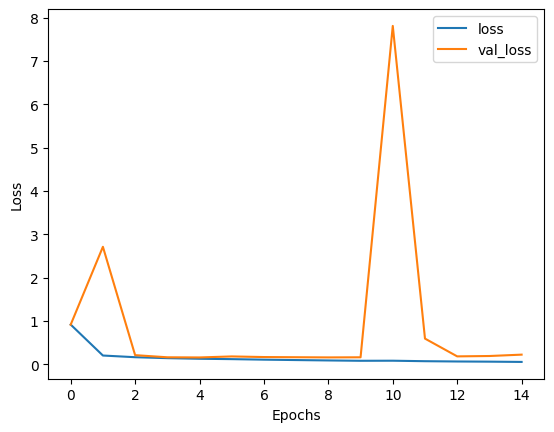

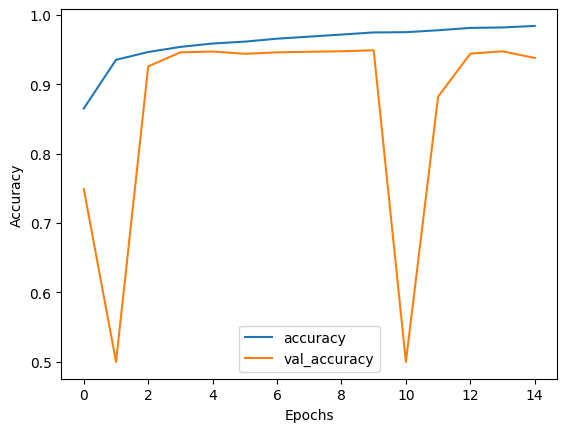

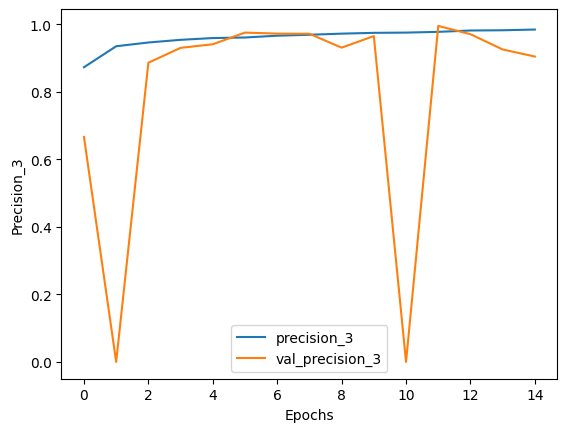

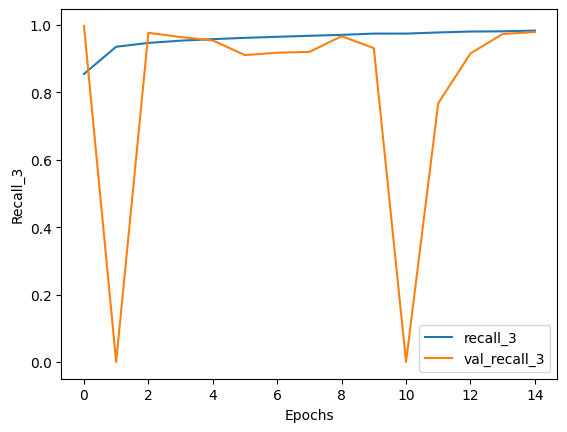

In [42]:
# Batch plot for MobileNet
for metric in ['loss', 'accuracy', 'precision_3', 'recall_3']:
    plot_metrics(MobileNet_model_history, metric, filename_prefix='mobilenet')

In [ ]:
# Save the MobileNet model
MobileNet_model.save("mobilenet.keras")

The model with EfficientNet as the base is the clear winner with an accuracy of 97.29%; however, MobileNet is also a great option since its model size is significantly lower than EfficientNet's, with a minor decrease in performance.